In [ ]:
from fastai.basics import *
from fastai.vision.all import *
from sklearn import metrics

/home/tiago/anaconda3/envs/fastai/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370151529/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from my_utils import dotdict

In [ ]:
from wandb_sweep import get_dls, get_learner

In [ ]:
from model_eval import get_preds, plot_CM, plot_CM_PR, plot_top_losses_glitches

In [ ]:
import wandb

api = wandb.Api()

In [ ]:
sweep_id = "m4nqsh6e"
sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")
best_run_config = sweep.best_run().config

wandb: Sorting runs by -summary_metrics.combined_f1_time


In [ ]:
config = dotdict(best_run_config)
config.correct_labels = True
config.inference = True
config.real_gw_eval = True

In [ ]:
config.real_gw_version = 6
# Samuel's version, selected samples, shifted

In [ ]:
dls, _, n_channels = get_dls(config)
learner = get_learner(config, dls, n_channels)
vocab = list(learner.dls.train_ds.class_dict.keys())
learner.load(f"{sweep_id}_run{config.experiment_no}")

<fastai.learner.Learner>

<matplotlib.image.AxesImage>

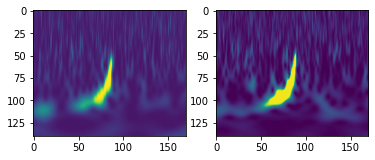

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1741][0][0])
axes[1].imshow(dls.loaders[2].dataset[0][0][0])

<matplotlib.image.AxesImage>

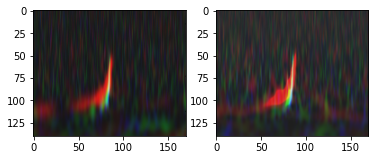

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1741][0].permute(1, 2, 0))
axes[1].imshow(dls.loaders[2].dataset[0][0].permute(1, 2, 0))

<matplotlib.image.AxesImage>

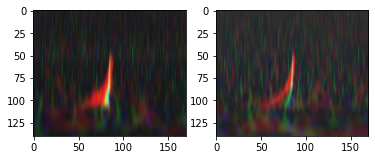

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1742][0].permute(1, 2, 0))
axes[1].imshow(dls.loaders[2].dataset[1][0].permute(1, 2, 0))

<matplotlib.image.AxesImage>

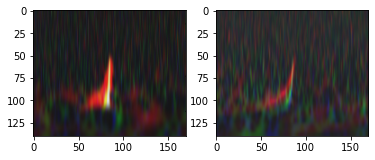

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1743][0].permute(1, 2, 0))
axes[1].imshow(dls.loaders[2].dataset[6][0].permute(1, 2, 0))

In [ ]:
dls.loaders[2].dataset[1][0].max()

tensor(0.8627)

In [ ]:
gws = dls[2].one_batch()
gws[0].mean(dim=[0, 2, 3]), gws[0].std(dim=[0, 2, 3])

(tensor([0.1846, 0.1797, 0.1783]), tensor([0.0705, 0.0489, 0.0403]))

In [ ]:
# mean of just 1 real gw event
gws[0][0].mean(dim=[1, 2]), gws[0][0].std(dim=[1, 2])

(tensor([0.1946, 0.1766, 0.1773]), tensor([0.1116, 0.0627, 0.0502]))

In [ ]:
# gspy stats:  
(tensor([0.1783, 0.1513, 0.1418]), tensor([0.1158, 0.0853, 0.0719]))

(tensor([0.1783, 0.1513, 0.1418]), tensor([0.1158, 0.0853, 0.0719]))

In [ ]:
dls.train_ds[1743][0].mean(dim=[1, 2]), dls.train_ds[1743][0].std(dim=[1, 2])

(tensor([0.1557, 0.1302, 0.1245]), tensor([0.1219, 0.0668, 0.0489]))

The real GWs have means and stds different thatn the original dset.  
They are even further than the Chirps present in gspy.

In [ ]:
preds, targets, soft_preds, y_true, y_pred = get_preds(learner, ds_idx=2)

In [ ]:
y_true, tensor([int(y) for y in y_pred])

(tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
 tensor([ 4,  4, 17, 12, 12, 17, 12,  4, 12, 17, 17, 17]))

In [ ]:
cm = metrics.confusion_matrix(y_true, y_pred, labels=np.arange(22))
acc = metrics.accuracy_score(y_true, y_pred) * 100
f1 = metrics.f1_score(y_true, y_pred, average="macro") * 100
print(f"Overall accuracy: {acc:.2f}%")
print(f"Macro-averaged F1-score: {f1:.2f}%")

Overall accuracy: 25.00%
Macro-averaged F1-score: 13.33%


In [ ]:
metrics.top_k_accuracy_score(y_true, soft_preds, labels=np.arange(22), k=5)

0.4166666666666667

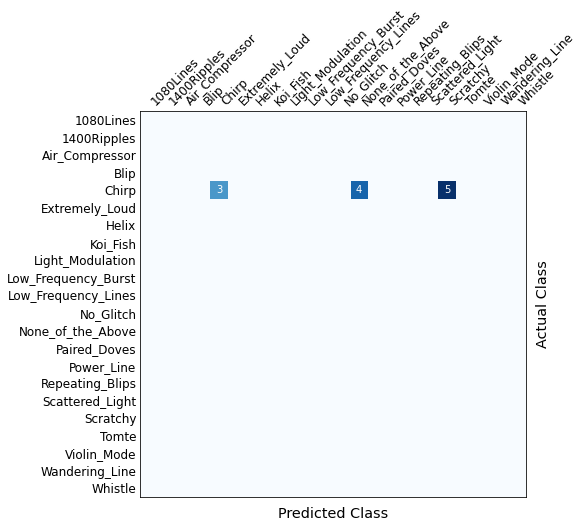

In [ ]:
fig, axes = plot_CM(cm, y_true=y_true, y_pred=y_pred, vocab=vocab, figsize=(8, 8))

In [ ]:
interp = Interpretation.from_learner(learner, ds_idx=2)
channel_list = [0] * 22

In [ ]:
from model_eval import plot_top_losses_gws

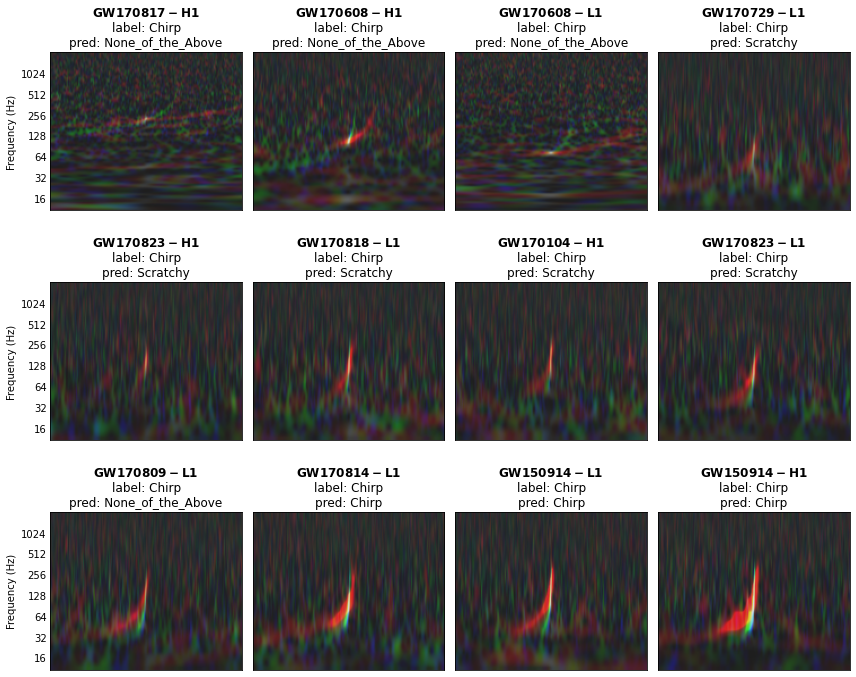

In [ ]:
fig, ax = plot_top_losses_gws(interp, learner, vocab=vocab, ds_idx=2,
    y_preds=y_pred,
    largest=True, nrows=3, ncols=4,
    show_label=True, show_pred=True, show_loss=False,
    figsize=(12, 10)
)

fig.savefig('../figs/glitches/18_real_gws_preds.pdf', dpi=600)

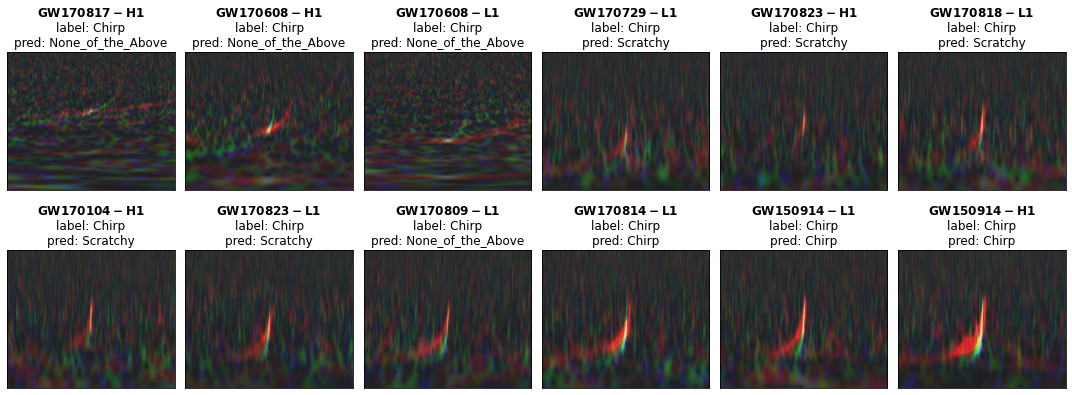

In [ ]:
fig, ax = plot_top_losses_gws(interp, learner, vocab=vocab, ds_idx=2,
    y_preds=y_pred,
    largest=True, nrows=2, ncols=6,
    show_label=True, show_pred=True, show_loss=False,
    figsize=(15, 6)
)
fig.tight_layout()

fig.savefig('../figs/glitches/18_real_gws_preds_v2.pdf', dpi=600)

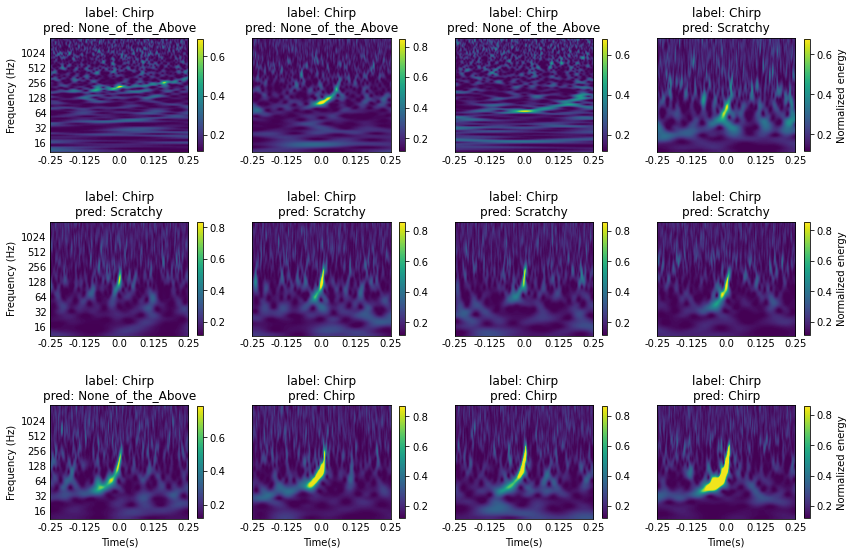

In [ ]:
fig, ax = plot_top_losses_glitches(interp, learner, vocab=vocab, ds_idx=2,
    y_preds=y_pred, channel_list=channel_list,
    largest=True, nrows=3, ncols=4,
    show_label=True, show_pred=True, show_loss=False,
    figsize=(12, 8)
)

In [ ]:
top_losses = interp.top_losses(12)

In [ ]:
for idx in top_losses[1][-12:]:
    top5 = preds[idx].topk(5)
    print([f'{vocab[idx]}: {top5[0][i]:.2e}' for i, idx in enumerate(top5[1])])

['None_of_the_Above: 8.49e-01', 'Scratchy: 1.47e-01', 'Low_Frequency_Lines: 1.68e-03', '1080Lines: 6.03e-04', 'Wandering_Line: 5.92e-04']
['None_of_the_Above: 9.06e-01', 'Scratchy: 9.25e-02', '1080Lines: 3.88e-04', 'Violin_Mode: 2.13e-04', 'Tomte: 1.68e-04']
['None_of_the_Above: 8.48e-01', 'Scratchy: 1.23e-01', '1080Lines: 2.31e-02', 'Whistle: 2.21e-03', 'Violin_Mode: 9.35e-04']
['Scratchy: 7.20e-01', 'None_of_the_Above: 2.70e-01', 'Tomte: 6.58e-03', 'No_Glitch: 1.55e-03', '1080Lines: 1.04e-03']
['Scratchy: 9.83e-01', 'None_of_the_Above: 1.35e-02', 'Whistle: 9.07e-04', 'No_Glitch: 7.30e-04', '1080Lines: 5.33e-04']
['Scratchy: 7.85e-01', 'None_of_the_Above: 2.13e-01', 'Tomte: 1.27e-03', 'Blip: 7.82e-04', '1080Lines: 2.79e-04']
['Scratchy: 9.72e-01', 'None_of_the_Above: 2.59e-02', 'Blip: 7.34e-04', 'Tomte: 2.20e-04', '1080Lines: 1.83e-04']
['Scratchy: 6.27e-01', 'None_of_the_Above: 2.91e-01', 'Chirp: 5.86e-02', 'Tomte: 9.10e-03', 'Power_Line: 5.64e-03']
['None_of_the_Above: 4.17e-01', 'S